In [35]:
from scipy.io.wavfile import read
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

### Load Audio File

In [23]:
rate, data = read('speaker_risa_01.wav')

In [24]:
data = data.astype(np.float)

In [27]:
data.shape

(488526, 2)

In [28]:
data_l = data[:, 0]
data_r = data[:, 1]

In [25]:
rate

44100

In [29]:
ipd.Audio(data=data_l, rate=rate)

### Convert audio signal to spectrogram

In [5]:
def spectrogram(
    signal: np.ndarray,
    n_fft: int=512,
    hop_length: int=256
) -> np.ndarray:
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    sp = librosa.amplitude_to_db(np.abs(stft))
    return sp

In [30]:
stft_kwargs = {
    'n_fft': 512,
    'hop_length': 512//4
}
istft_kwargs = {
    'hop_length': 512//4
}

In [32]:
sp = spectrogram(data_l, **stft_kwargs)

In [45]:
sp

array([[63.87112 , 65.79024 , 62.697205, ..., 39.861206, 39.861206,
        39.861206],
       [41.734585, 64.208496, 61.11522 , ..., 39.861206, 39.861206,
        39.861206],
       [58.753506, 60.00566 , 60.81634 , ..., 39.861206, 39.861206,
        39.861206],
       ...,
       [39.861206, 39.861206, 39.861206, ..., 39.861206, 39.861206,
        39.861206],
       [39.861206, 39.861206, 39.861206, ..., 39.861206, 39.861206,
        39.861206],
       [39.861206, 39.861206, 39.861206, ..., 39.861206, 39.861206,
        39.861206]], dtype=float32)

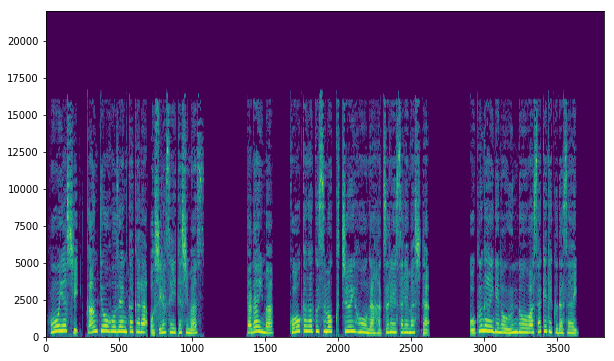

In [41]:
plt.figure(figsize=(10, 6))
plt.imshow(sp, origin='lower', aspect='auto', extent=(0, sp.shape[1], 0, rate//2))

### Invert spectrogram to audio signal

In [47]:
# https://github.com/rbarghou/pygriffinlim/blob/master/pygriffinlim/griffinlim.py
def griffin_lim_generator(
        spectrogram,
        iterations=40,
        approximated_signal=None,
        stft_kwargs={},
        istft_kwargs={}):
    """
    Implements the basic Griffin Lim algorithm.
    Returns a generator that outputs the approximated signal at the various iterations.
    :param spectrogram: The Spectrogram from which reconstruction should begin
    :param iterations: The number of iterations you want to perform reconstruction with.
    :param approximated_signal: if you want to begin with an existing approximated signal
    :param stft_kwargs: The arguments to pass to STFT as defined by the librosa
    implementation of these functions.
    :param istft_kwargs: The arguments to pass to ISTFT as defined by the librosa
    implementation of these functions.
    :return generator:  This is a generator of approximated signals at each iteration of
    the griffin lim algorithm
    """
    _M = spectrogram
    for k in range(iterations):
        if approximated_signal is None:
            _P = np.random.randn(*_M.shape)
        else:
            _D = librosa.stft(approximated_signal, **stft_kwargs)
            _P = np.angle(_D)

        _D = _M * np.exp(1j * _P)
        approximated_signal = librosa.istft(_D, **istft_kwargs)
    
    return approximated_signal

In [48]:
signal_reconstructed = griffin_lim_generator(
    spectrogram=librosa.db_to_amplitude(sp),
    stft_kwargs=stft_kwargs,
    istft_kwargs=istft_kwargs
)

In [49]:
ipd.Audio(data=signal_reconstructed, rate=rate)

### Re-convert reconstructed audio signal to spectrogram

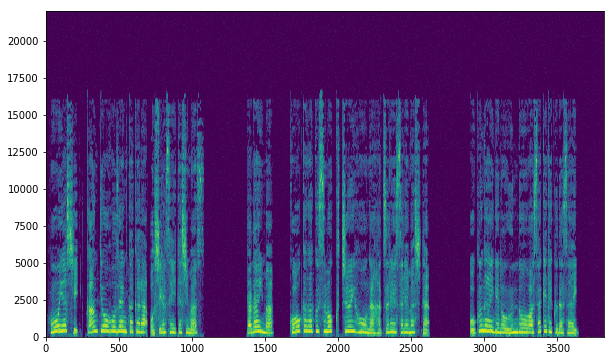

In [50]:
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram(signal_reconstructed, **stft_kwargs), origin='lower', aspect='auto', extent=(0, sp.shape[1], 0, rate//2))